In [1]:
from lib import models, graph, coarsening, utils

C:\Users\silus\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
C:\Users\silus\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
from load_and_preprocessing import load_data_and_filter_members, assign_party_to_names
import numpy as np
import matplotlib.pyplot as plt
import requests
import scipy.sparse as sp

Method: Use councillor network (Adjacency N x N) constructed by evaluating voting similarity over a certain period of time as underlying structure of data 
The signals that should be classified consist of the votes of each concillor on an affair (1 x N) that can be associated to one of the following topics:

Creating the adjacency:

In [3]:
# Use load_data_and_filter_members to create adjacency for any file from any legislature
# Example 
leg='50'
from_date = None
to_date = None
data_transf, adjacency, node_index, affairs_features, sum_na_per_row = load_data_and_filter_members('../data/abdb-de-all-affairs-'+leg+'-0.csv',
                                                                     start_date=from_date, end_date=to_date,
                                                                     filter_method='number_NA',cutoff=10,ret_transf=True, delete_links_below=0.8 )

(Nbr. of councillors, nbr. of votes) before filter: (221, 1320)
(Nbr. of councillors, nbr. of votes) after filter: (175, 1320)


Get data (affairs) with desired labels (Topic of the vote) via http request:

In [ ]:
affairs = affairs_features.index.values.astype(str)
#labels_filter = ['Umwelt','Energie','Europapolitik','52', '10', '66']
#label_dict = {'Umwelt':'52','Energie':'66','Europapolitik':'10'}
labels_filter = ['Finanzwesen','Wirtschaft','Europapolitik','24', '15', '10']
label_dict = {'Finanzwesen':'24','Wirtschaft':'15','Europapolitik':'10'}
train_affairs = []
train_labels = []
for affair in affairs:
    r = requests.get('http://ws-old.parlament.ch/affairs/'+affair+'?format=json', headers={'accept': 'text/json'})
    r = r.json()
    if 'additionalIndexing' in r:
        additionalIndices = r['additionalIndexing']
    else:
        continue
    for label in labels_filter:
        if label in additionalIndices:
            train_affairs.append(affair.astype(int))
            if label in label_dict.keys():
                train_labels.append(label_dict[label])
            else:
                train_labels.append(label)
                
train_affairs_index = affairs_features.loc[train_affairs,:].values[:,0]
X = data_transf[train_affairs_index].values.T.astype(np.float32)

class_dict = {'24':0,'15':1,'10':2}
y = np.array([class_dict[label] for label in train_labels])

In [80]:
X = np.load('X_train.npy')
y = np.load('y_train.npy')

X[X==0] = -1
X[X==0.5] = 0

n = X.shape[0]
d = X.shape[1]

n_train = n // 2
n_val = n // 10

X_train = X[:n_train]
X_val   = X[n_train:n_train+n_val]
X_test  = X[n_train+n_val:]

y_train = y[:n_train]
y_val   = y[n_train:n_train+n_val]
y_test  = y[n_train+n_val:]

In [85]:
print(y_test.shape)
X_train=np.concatenate((X_train, X_test), axis=0)
y_train = np.concatenate((y_train, y_test))

(241,)


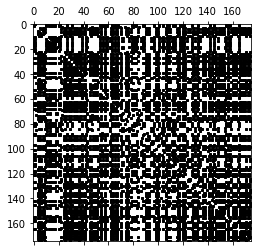

In [86]:
assert adjacency.shape == (d, d)
plt.spy(adjacency, markersize=2, color='black');

In [87]:
graphs, perm = coarsening.coarsen(sp.csr_matrix(adjacency.astype(np.float32)), levels=5, self_connections=False)
#graphs, perm = coarsening.coarsen(A, levels=3, self_connections=False)

X_train = coarsening.perm_data(X_train, perm)
X_val = coarsening.perm_data(X_val, perm)
X_test = coarsening.perm_data(X_test, perm)

Layer 0: M_0 = |V| = 192 nodes (17 added),|E| = 3678 edges
Layer 1: M_1 = |V| = 96 nodes (6 added),|E| = 1981 edges
Layer 2: M_2 = |V| = 48 nodes (2 added),|E| = 562 edges
Layer 3: M_3 = |V| = 24 nodes (1 added),|E| = 162 edges
Layer 4: M_4 = |V| = 12 nodes (0 added),|E| = 53 edges
Layer 5: M_5 = |V| = 6 nodes (0 added),|E| = 15 edges


C:\Users\silus\conseil_national\Final_Project\lib\coarsening.py:152: RuntimeWarning: divide by zero encountered in true_divide
  tval = vv[rs+jj] * (1.0/weights[tid] + 1.0/weights[nid])


C:\Users\silus\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


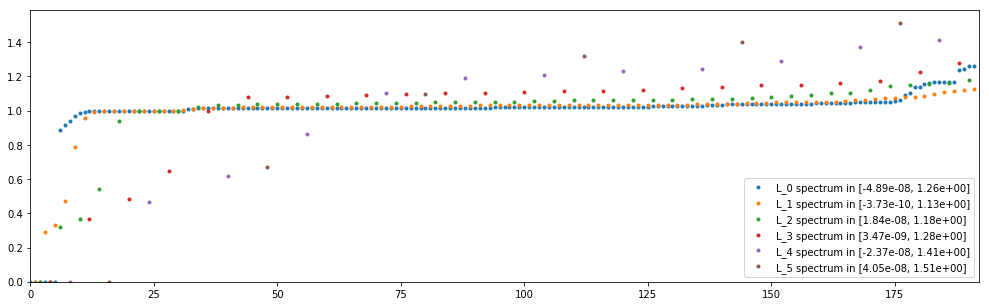

In [88]:
L = [graph.laplacian(A, normalized=True) for A in graphs]
graph.plot_spectrum(L)

Apply ConvNet

In [147]:
params = dict()
params['dir_name']       = 'demo'
params['num_epochs']     = 20
params['batch_size']     = 30
params['eval_frequency'] = 20

# Building blocks.
params['filter']         = 'chebyshev5'
params['brelu']          = 'b1relu'
params['pool']           = 'apool1'

# Number of classes.
C = y.max() + 1
assert C == np.unique(y).size

# Architecture.
params['F']              = [16, 32]  # Number of graph convolutional filters.
params['K']              = [10, 10]  # Polynomial orders.
params['p']              = [8, 4]    # Pooling sizes.
params['M']              = [256, C]  # Output dimensionality of fully connected layers.

# Optimization.
params['regularization'] = 4e-5
params['dropout']        = 1
params['learning_rate']  = 6e-2
params['decay_rate']     = 0.9
params['momentum']       = 0.8
params['decay_steps']    = n_train / params['batch_size']

In [148]:
model = models.cgcnn(L, **params)
accuracy, loss, t_step = model.fit(X_train, y_train, X_val, y_val)

NN architecture
  input: M_0 = 192
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 192 * 16 / 8 = 384
    weights: F_0 * F_1 * K_1 = 1 * 16 * 10 = 160
    biases: F_1 = 16
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 24 * 32 / 4 = 192
    weights: F_1 * F_2 * K_2 = 16 * 32 * 10 = 5120
    biases: F_2 = 32
  layer 3: fc1
    representation: M_3 = 256
    weights: M_2 * M_3 = 192 * 256 = 49152
    biases: M_3 = 256
  layer 4: logits (softmax)
    representation: M_4 = 3
    weights: M_3 * M_4 = 256 * 3 = 768
    biases: M_4 = 3
step 20 / 360 (epoch 1.11 / 20):
  learning_rate = 5.40e-02, loss_average = 8.59e-01


C:\Users\silus\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 52.54 (31 / 59), f1 (weighted): 36.20, loss: 1.07e+00
  time: 7s (wall 6s)
step 40 / 360 (epoch 2.22 / 20):
  learning_rate = 4.37e-02, loss_average = 9.73e-01
  validation accuracy: 52.54 (31 / 59), f1 (weighted): 36.20, loss: 9.98e-01
  time: 14s (wall 10s)
step 60 / 360 (epoch 3.33 / 20):
  learning_rate = 3.54e-02, loss_average = 9.74e-01
  validation accuracy: 52.54 (31 / 59), f1 (weighted): 36.20, loss: 9.92e-01
  time: 20s (wall 14s)
step 80 / 360 (epoch 4.44 / 20):
  learning_rate = 2.87e-02, loss_average = 9.68e-01
  validation accuracy: 52.54 (31 / 59), f1 (weighted): 36.20, loss: 9.90e-01
  time: 26s (wall 18s)
step 100 / 360 (epoch 5.56 / 20):
  learning_rate = 2.32e-02, loss_average = 9.51e-01
  validation accuracy: 52.54 (31 / 59), f1 (weighted): 36.20, loss: 9.82e-01
  time: 31s (wall 22s)
step 120 / 360 (epoch 6.67 / 20):
  learning_rate = 1.88e-02, loss_average = 9.66e-01
  validation accuracy: 52.54 (31 / 59), f1 (weighted): 36.20, loss: 9.80e-0

Look at train loss and validation set accuracy:

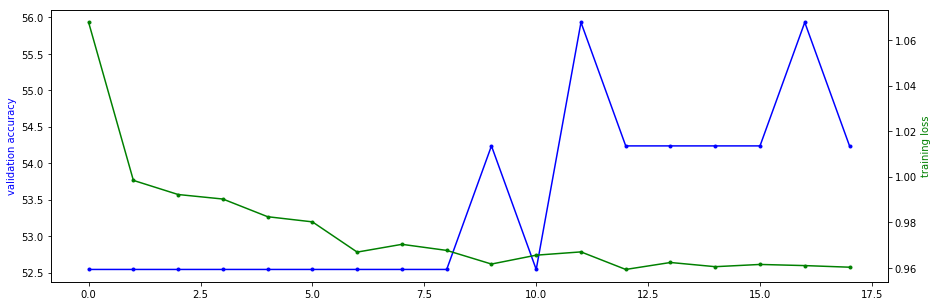

In [149]:
fig, ax1 = plt.subplots(figsize=(15, 5))
ax1.plot(accuracy, 'b.-')
ax1.set_ylabel('validation accuracy', color='b')
ax2 = ax1.twinx()
ax2.plot(loss, 'g.-')
ax2.set_ylabel('training loss', color='g')
plt.show()



Evaluate on test set:

In [78]:
res = model.evaluate(X_test, y_test)
print(res[0])

INFO:tensorflow:Restoring parameters from C:\Users\silus\conseil_national\Final_Project\lib\..\checkpoints\demo\model-299
accuracy: 48.07 (87 / 181), f1 (weighted): 31.21, loss: 1.02e+00
time: 2s (wall 1s)


C:\Users\silus\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
